
# Wildfires Forecasting Model
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

from datetime import date, timedelta, datetime
import itertools


%matplotlib inline

### Loading Data

In [2]:
data_path = '../data/'

df1 = pd.read_csv(f'{data_path}/Historical_Wildfires.csv')
df2 = pd.read_csv(f'{data_path}/HistoricalWeather.csv')
df3 = pd.read_csv(f'{data_path}/HistoricalWeatherForecasts.csv')
df4 = pd.read_csv(f'{data_path}/LandClass.csv')
df5 = pd.read_csv(f'{data_path}/VegetationIndex.csv')

In [3]:
df1

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.680000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.611250,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.520000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.264000,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.400000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R
...,...,...,...,...,...,...,...,...,...,...
26401,WA,10/27/2020,32.970000,324.068182,103.318182,84.363636,5.277741,27.854545,11,N
26402,WA,10/28/2020,20.840625,314.425000,37.256250,88.312500,8.121730,65.962500,16,N
26403,WA,10/29/2020,136.083077,323.588461,294.102564,92.974359,8.282789,68.604588,39,N
26404,WA,10/30/2020,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N


In [4]:
df2

,Date,Region,Parameter,count()[unit: km^2],min(),max(),mean(),variance()
0,2005-01-01,NSW,Precipitation,8.002343e+05,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,8.002343e+05,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,8.002343e+05,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,8.002343e+05,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,8.002343e+05,14.485785,35.878704,27.341182,18.562212
...,...,...,...,...,...,...,...,...
242776,2020-10-31,WA,RelativeHumidity,2.528546e+06,9.272744,82.022224,34.193973,309.018764
242777,2020-10-31,WA,SoilWaterContent,2.528546e+06,0.000000,0.285399,0.050737,0.001419
242778,2020-10-31,WA,SolarRadiation,2.528546e+06,17.072290,29.743744,26.746413,5.986063
242779,2020-10-31,WA,Temperature,2.528546e+06,16.238239,34.669132,28.090392,15.293953


In [5]:
df3

,Date,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002
...,...,...,...,...,...,...,...,...,...
217207,2020-10-31,WA,Temperature,10,2.542548e+06,16.062984,34.801270,26.999880,14.610838
217208,2020-10-31,WA,Temperature,15,2.542548e+06,12.785835,36.613548,28.529795,32.340741
217209,2020-10-31,WA,WindSpeed,5,2.542548e+06,1.311029,9.138333,5.245600,2.626650
217210,2020-10-31,WA,WindSpeed,10,2.542548e+06,0.365395,10.549594,5.451390,2.232168


In [6]:
df4

,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0
5,WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8
6,VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9


In [7]:
df5

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,1/1/2005,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2/1/2005,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,3/1/2005,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,4/1/2005,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,5/1/2005,0.345526,0.9972,-0.2,0.202858,0.041151
...,...,...,...,...,...,...,...
1325,WA,6/1/2020,0.263760,0.9886,-0.2,0.129103,0.016667
1326,WA,7/1/2020,0.265321,0.9941,-0.2,0.148663,0.022101
1327,WA,8/1/2020,0.255785,0.9692,-0.2,0.155347,0.024133
1328,WA,9/1/2020,0.234510,0.9849,-0.2,0.126898,0.016103


### Format each dataframe to Day/Region based 

In [8]:
def trans_Hist_Weather(df) :
    
    df = df.rename(columns = {'count()[unit: km^2]' : 'Area', 'min()' : 'Min',
                               'max()' : 'Max', 'mean()' : 'Mean', 'variance()' : 'Variance'})
    df = df.pivot_table(values=['Min','Max','Mean','Variance'], index=['Date','Region'],
                                      columns=['Parameter'])
    df.reset_index(inplace = True)
    df.columns = [c[0] if c[1] == '' else f'{c[1]}_{c[0]}' for c in df.columns.values]
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

def trans_Hist_Weather_Forecast(df) :
    
    df = df.rename(columns = {'count()[unit: km^2]' : 'Area', 'min()' : 'Min',
                                   'max()' : 'Max', 'mean()' : 'Mean', 'variance()' : 'Variance'})
    df = df.pivot_table(values = ['Min','Max','Mean','Variance'], index = ['Date','Region'],
                                 columns = ['Parameter', 'Lead time'])
    df.reset_index(inplace = True)
    df.columns = [c[0] if c[1] == '' else f'{c[1]}_{c[0]}_{c[2]}' for c in df.columns.values]
    df.fillna(0, inplace=True) #missing 
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df


In [9]:
df2 = trans_Hist_Weather(df2)
df3 = trans_Hist_Weather_Forecast(df3)

### Finding missing date and time

In [10]:
def find_missing_date(df, start_date = (2005,1,1), end_date = (2020,10,31), 
                      region = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], date_col = 'Date') :
    
    df['Date'] = pd.to_datetime(df['Date'])
    start_date = date(start_date[0], start_date[1], start_date[2])
    end_date = date(end_date[0], end_date[1], end_date[2])
    total_date_set = set([start_date + timedelta(x) for x in range((end_date- start_date).days)])
    
    missing = dict()
    for reg in region : 
        df_temp = df[df['Region'] == reg]
        date_list = list(df_temp[date_col])
        date_set = set([ts.date() for ts in date_list])
        
        missing[reg] = total_date_set - date_set
        
    return missing

## Experiment #1
### Univariate Forecasting 
1. Try 30d timesteps forecasting
2. Lag Time for 30 day
3. See Result
4. Only NSW Region
5. Use Historical Wildfire data only

In [11]:
#find missing date
find_missing_date(df1, region = ['NSW'])

{'NSW': {datetime.date(2008, 2, 7),
  datetime.date(2018, 12, 12),
  datetime.date(2012, 7, 13),
  datetime.date(2007, 11, 25),
  datetime.date(2011, 11, 17),
  datetime.date(2008, 11, 20),
  datetime.date(2011, 12, 27),
  datetime.date(2009, 4, 12),
  datetime.date(2008, 10, 24),
  datetime.date(2010, 1, 31),
  datetime.date(2020, 8, 22),
  datetime.date(2016, 8, 4),
  datetime.date(2007, 12, 26),
  datetime.date(2016, 6, 21),
  datetime.date(2008, 1, 25),
  datetime.date(2009, 3, 15),
  datetime.date(2008, 1, 8),
  datetime.date(2010, 2, 20),
  datetime.date(2006, 1, 27),
  datetime.date(2013, 2, 3),
  datetime.date(2010, 10, 8),
  datetime.date(2020, 2, 23),
  datetime.date(2008, 7, 6),
  datetime.date(2016, 7, 23),
  datetime.date(2007, 6, 29),
  datetime.date(2007, 3, 2),
  datetime.date(2016, 9, 18),
  datetime.date(2008, 7, 11),
  datetime.date(2017, 1, 6),
  datetime.date(2014, 6, 14),
  datetime.date(2007, 12, 27),
  datetime.date(2017, 6, 1),
  datetime.date(2010, 12, 8),
  d

In [12]:
find_missing_date(df2, region = ['NSW'])

{'NSW': set()}

In [13]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1_temp = df1.copy()
df1_temp = df1[df1['Region'] == 'NSW']
df1_temp.reset_index(inplace = True)
df1_temp

,index,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R
...,...,...,...,...,...,...,...,...,...,...,...
4618,4618,NSW,2020-10-25,3.00000,324.233333,27.966667,86.666667,3.511885,12.333333,3,N
4619,4619,NSW,2020-10-27,1.21000,311.100000,16.800000,78.000000,NaN,NaN,1,N
4620,4620,NSW,2020-10-28,3.00000,323.166667,20.566667,82.333333,4.509250,20.333333,3,N
4621,4621,NSW,2020-10-30,1.32000,315.100000,13.700000,76.000000,NaN,NaN,1,N


In [14]:
df2_temp = df2.copy()
df2_temp = df2[df2['Region'] == 'NSW']
df2_temp.reset_index(inplace = True)
df2_temp

,index,Date,Region,Precipitation_Max,RelativeHumidity_Max,SoilWaterContent_Max,SolarRadiation_Max,Temperature_Max,WindSpeed_Max,Precipitation_Mean,...,SoilWaterContent_Min,SolarRadiation_Min,Temperature_Min,WindSpeed_Min,Precipitation_Variance,RelativeHumidity_Variance,SoilWaterContent_Variance,SolarRadiation_Variance,Temperature_Variance,WindSpeed_Variance
0,0,2005-01-01,NSW,1.836935,80.522964,0.414305,32.169781,35.878704,7.670482,0.044274,...,0.002245,14.515009,14.485785,1.354448,0.028362,253.559937,0.007758,6.078587,18.562212,0.850048
1,7,2005-01-02,NSW,6.854537,86.243828,0.404071,34.308487,33.976604,7.448905,0.173879,...,0.001210,15.775055,12.067627,0.864556,0.271386,224.769253,0.007293,11.737577,22.320857,0.470928
2,14,2005-01-03,NSW,14.969810,88.527359,0.405569,32.525158,34.744976,8.515941,3.011912,...,0.010889,15.362626,16.858456,1.435490,10.308246,167.044018,0.006598,6.106235,16.619341,2.002952
3,21,2005-01-04,NSW,22.842566,90.332771,0.444927,33.214062,28.945488,7.364222,2.808620,...,0.022578,7.576938,12.495799,1.401951,17.383363,267.158378,0.009965,40.255460,9.455474,1.494301
4,28,2005-01-05,NSW,7.657155,88.623436,0.442955,33.554867,29.510120,7.091141,0.157935,...,0.019950,14.087289,9.611800,1.011328,0.273471,195.639724,0.009483,29.763055,13.352380,1.043316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5778,40446,2020-10-27,NSW,58.436600,97.393547,0.468511,29.975296,22.218430,5.497386,2.124025,...,0.007598,8.514027,7.288919,1.036175,19.255058,305.295409,0.013978,23.311615,8.529138,0.613602
5779,40453,2020-10-28,NSW,30.506205,93.729408,0.494503,29.948700,22.422768,4.353423,4.350241,...,0.000000,9.952868,8.654533,0.790777,33.377184,363.242021,0.016336,12.846223,7.148141,0.562205
5780,40460,2020-10-29,NSW,16.275040,91.932632,0.480009,29.375010,24.129215,7.925164,2.342508,...,0.004790,15.170402,9.860389,0.663298,12.204651,326.339825,0.015407,9.261971,11.601502,2.072462
5781,40467,2020-10-30,NSW,46.937473,89.295311,0.484731,29.318480,24.310499,8.527669,6.023114,...,0.008776,8.277431,10.133630,1.465277,48.708134,272.160953,0.014347,17.436028,6.171237,2.912816


In [15]:
df = pd.merge(df1_temp, df2_temp, how='inner', on=['Date','Region']).drop('index_x', axis = 1)

## Note that there were lot of missing targets (5783 - 4623 = 1160 days)
df

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,...,SoilWaterContent_Min,SolarRadiation_Min,Temperature_Min,WindSpeed_Min,Precipitation_Variance,RelativeHumidity_Variance,SoilWaterContent_Variance,SolarRadiation_Variance,Temperature_Variance,WindSpeed_Variance
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,...,0.022578,7.576938,12.495799,1.401951,17.383363,267.158378,0.009965,40.255460,9.455474,1.494301
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,...,0.019950,14.087289,9.611800,1.011328,0.273471,195.639724,0.009483,29.763055,13.352380,1.043316
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,...,0.020037,12.310518,9.024039,0.930842,4.634465,213.300558,0.008750,22.667707,11.764178,1.953685
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,...,0.018115,16.044561,8.691216,1.601724,0.038927,245.624576,0.007799,6.949267,7.940373,1.102751
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,...,0.014398,15.209880,10.821342,1.167861,0.236269,342.996833,0.007482,27.822830,12.063971,0.774612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,NSW,2020-10-25,3.00000,324.233333,27.966667,86.666667,3.511885,12.333333,3,N,...,0.029187,2.952551,4.655551,1.107591,54.916094,342.426826,0.012537,59.706485,6.921498,1.977909
4619,NSW,2020-10-27,1.21000,311.100000,16.800000,78.000000,NaN,NaN,1,N,...,0.007598,8.514027,7.288919,1.036175,19.255058,305.295409,0.013978,23.311615,8.529138,0.613602
4620,NSW,2020-10-28,3.00000,323.166667,20.566667,82.333333,4.509250,20.333333,3,N,...,0.000000,9.952868,8.654533,0.790777,33.377184,363.242021,0.016336,12.846223,7.148141,0.562205
4621,NSW,2020-10-30,1.32000,315.100000,13.700000,76.000000,NaN,NaN,1,N,...,0.008776,8.277431,10.133630,1.465277,48.708134,272.160953,0.014347,17.436028,6.171237,2.912816


In [16]:
df[['Date','Region']].values

array([[Timestamp('2005-01-04 00:00:00'), 'NSW'],
       [Timestamp('2005-01-05 00:00:00'), 'NSW'],
       [Timestamp('2005-01-06 00:00:00'), 'NSW'],
       ...,
       [Timestamp('2020-10-28 00:00:00'), 'NSW'],
       [Timestamp('2020-10-30 00:00:00'), 'NSW'],
       [Timestamp('2020-10-31 00:00:00'), 'NSW']], dtype=object)

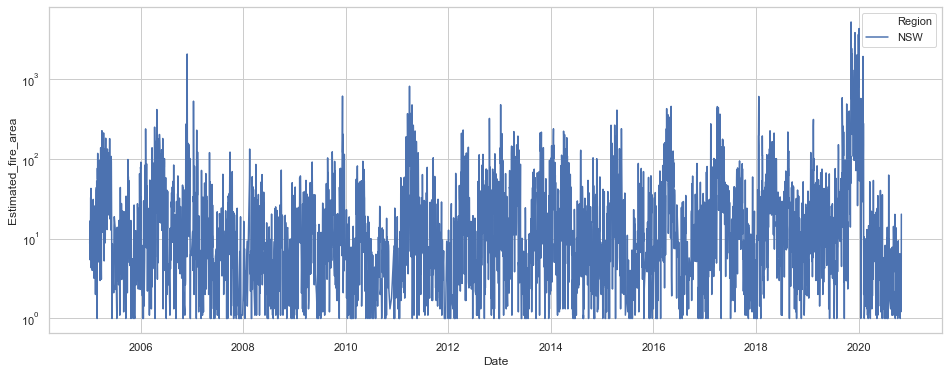

In [17]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region',
                 data=df)
g.set_yscale("log")

In [18]:
df['Date'][0].date().year
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [19]:
df.columns.values

array(['Region', 'Date', 'Estimated_fire_area',
       'Mean_estimated_fire_brightness',
       'Mean_estimated_fire_radiative_power', 'Mean_confidence',
       'Std_confidence', 'Var_confidence', 'Count', 'Replaced', 'index_y',
       'Precipitation_Max', 'RelativeHumidity_Max',
       'SoilWaterContent_Max', 'SolarRadiation_Max', 'Temperature_Max',
       'WindSpeed_Max', 'Precipitation_Mean', 'RelativeHumidity_Mean',
       'SoilWaterContent_Mean', 'SolarRadiation_Mean', 'Temperature_Mean',
       'WindSpeed_Mean', 'Precipitation_Min', 'RelativeHumidity_Min',
       'SoilWaterContent_Min', 'SolarRadiation_Min', 'Temperature_Min',
       'WindSpeed_Min', 'Precipitation_Variance',
       'RelativeHumidity_Variance', 'SoilWaterContent_Variance',
       'SolarRadiation_Variance', 'Temperature_Variance',
       'WindSpeed_Variance', 'Year'], dtype=object)

In [20]:
annually = df[['Year', 'Estimated_fire_area']].groupby('Year').mean().copy()
plt.figure(figsize = (16,6))
sns.set(style = "whitegrid")
sns.lineplot(x = "Year", y = "Estimated_fire_area", data=annually)

#quite stationary except 2019-2020 (especailly  2019)

ValueError: Could not interpret input 'Year'

<Figure size 1152x432 with 0 Axes>

In [43]:
def gen_supervise(df, ft_cols = None, tgt_col = 'Estimated_fire_area', lag = 7, forecast = 30) :

    ft = list(df.values)
    tgt = list(df[tgt_col].values)
    
    ft = [ft[i:i+lag] for i in range(len(tgt)-forecast-lag+1)]
    ft = np.array([list(itertools.chain(*temp)) for temp in ft])
    target = np.array([tgt[i : i + forecast] for i in range(lag,len(tgt)-forecast+1)])
    
    return ft, target

    
def prepared_data(df, split = 0.8, lag = 30, forecast = 30, ft_cols = None) :

    if ft_cols == None :
        ft_cols = [ft for ft in df.columns.values if ft not in ['Date', 'Region','Replaced']]
    ttl_rows =  len(df.index.values)
    temp_df = df[ft_cols]
    
    split_idx = round(split*ttl_rows)
    scaler = MinMaxScaler(feature_range=(0,1))
    train, test = temp_df.iloc[:split_idx, :], temp_df.iloc[split_idx:, :]
    
    scaled_train = scaler.fit_transform(train)
    scaled_train_df = pd.DataFrame(scaled_train, columns=ft_cols)
    scaled_test = scaler.transform(test)
    scaled_test_df = pd.DataFrame(scaled_test, columns=ft_cols)
    
    scaled_data = dict()
    scaled_data['X_train'], scaled_data['y_train'] = gen_supervise(scaled_train_df, lag = lag, forecast = forecast, ft_cols = ft_cols)
    scaled_data['X_test'], scaled_data['y_test'] = gen_supervise(scaled_test_df, lag = lag, forecast = forecast)
    
    data = dict()
    data['X_train'], data['y_train'] = gen_supervise(train, lag = lag, forecast = forecast, ft_cols = ft_cols)
    data['X_test'], data['y_test'] = gen_supervise(test, lag = lag, forecast = forecast, ft_cols = ft_cols)
    
    return scaler, data, scaled_data, train, test
      

In [44]:
scaler, data, scaled_data, _, test = prepared_data(df, forecast=7, lag=15,ft_cols = ['Estimated_fire_area','Mean_estimated_fire_brightness','Mean_estimated_fire_radiative_power']) 

In [23]:
print(data['X_train'].shape)
print(data['y_train'].shape)
print(data['X_test'].shape)
print(data['y_test'].shape)

(3677, 45)
(3677, 7)
(904, 45)
(904, 7)


In [24]:
def LSTM_model(data, opt_params, n_batch=1, nb_epoch=500, n_neurons=32):
    # reshape training into [samples, timesteps, features]
    X, y = data['X_train'], data['y_train']
    X = X.reshape(X.shape[0], 1, X.shape[1])
    log = []
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    opt = Adam(**opt_params)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    # fit network
    for i in range(nb_epoch):
        history = model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        print(f'''training at iteration : {i+1}/{nb_epoch} --- train_loss : {history.history['loss']}''')
        log.append(history.history['loss'][0])
        model.reset_states()
    return model, log

In [25]:
def LSTM_forecast(df, model, scaler, n_batch = 1, lag = 30, forecast = 30, ft_cols = None) :
    if ft_cols == None :
        ft_cols = [ft for ft in df.columns.values if ft not in ['Date', 'Region','Replaced']]
    scaled_test = scaler.transform(df)
    scaled_test_df = pd.DataFrame(scaled_test, columns = ft_cols)
    X_test, y_test = gen_supervise(scaled_test_df,lag = lag, forecast = forecast, ft_cols = ft_cols)
    test_size = X_test.shape[0]
    pred = []
    for i in range(test_size) :
        X = X_test[i]
        X = X.reshape(1,1,X.shape[0])
        res = model.predict(X, batch_size = n_batch)
        pred.append(res[0])
    return pred

def inverse_pred(scaler, pred) :
    y_hat = []
    
    #the prediction is scaled -> inverse scale back
    tgt_scaler = MinMaxScaler()
    tgt_scaler.min_, tgt_scaler.scale_ = scaler.min_[0], scaler.scale_[0] #index of the target feature b4 transform
    for p in pred :
        inverted = tgt_scaler.inverse_transform(p.reshape(p.shape[0],1)).reshape(p.shape[0])
        y_hat.append(inverted)       
    return np.array(y_hat)

In [30]:
opt_params = {
    'lr' : 0.05,
    'beta_1' : 0.9,
    'beta_2' : 0.999,
    'decay' : 0.01
}

model = LSTM_model(scaled_data,opt_params, nb_epoch=10)

training at iteration : 1/10 --- train_loss : [0.0009048421634361148]
training at iteration : 2/10 --- train_loss : [0.0008185135666280985]
training at iteration : 3/10 --- train_loss : [0.0008251338731497526]
training at iteration : 4/10 --- train_loss : [0.0008132054354064167]
training at iteration : 5/10 --- train_loss : [0.0007935735047794878]
training at iteration : 6/10 --- train_loss : [0.0007769966032356024]
training at iteration : 7/10 --- train_loss : [0.0007653150241822004]
training at iteration : 8/10 --- train_loss : [0.0007573174661956728]
training at iteration : 9/10 --- train_loss : [0.0007516864570789039]
training at iteration : 10/10 --- train_loss : [0.0007475529564544559]


In [52]:
pred = LSTM_forecast(test,model[0],scaler)
pred

ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1150 predict_function  *
        outputs = self.distribute_strategy.run(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1125 predict_step  **
        return self(x, training=False)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:224 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_2: expected shape=(1, None, 45), found shape=[1, 1, 90]


In [50]:
model[0]

In [ ]:
y_hat = scale_prediction(scaler, data, pred)
np.sqrt(mean_squared_error(data['y_test'], y_hat))

In [ ]:
np.sqrt(mean_squared_error(scaled_data['y_test'],pred))

# Process Flow
## 1. Data Preparation 
## 2. Model trainning
## 3. Model evaluation
## 4. Saving Model and metadata
## 5. Load Model

In [ ]:
'''data configuration'''

forecast = 7 #num of days to forecast
lag = 15 #num of days lagged back (as input features)
ft_cols = ['Estimated_fire_area','Mean_estimated_fire_brightness','Mean_estimated_fire_radiative_power'] #at least Estimated_fire_area should be included(univariate)
split = 0.8 #train ratio
states = ['NSW'] #selected region


'''model configuration'''

opt_params = { #optimizer params
    'lr' : 0.05, 
    'beta_1' : 0.9,
    'beta_2' : 0.999,
    'decay' : 0.005
} 
model_params = {
    'n_batch' : 1, #should be divisibled to the trainning size (just fix it to one in this case)
    'nb_epoch' : 100, #num of trainning iterations
    'n_neurons' : 25, #hidden units for each LSTM layer
    'opt_params' : opt_params
}

## Data preparation


In [ ]:
df1['Date'] = pd.to_datetime(df1['Date']) #df1 = estimated fire area dataFrame
df1_temp = df1.copy()
df1_temp = df1_temp[df1_temp['Region'].isin(states)]
df1_temp.reset_index(inplace = True)

df2['Date'] = pd.to_datetime(df2['Date'])
df2_temp = df2.copy()
df2_temp = df2_temp[df2_temp['Region'].isin(states)]
df2_temp.reset_index(inplace = True)

df = pd.merge(df1_temp, df2_temp, how='inner', on=['Date','Region']).drop('index_x', axis = 1)
scaler, data, scaled_data, train, test = prepared_data(df, forecast=forecast, lag=lag, ft_cols = ft_cols) 

In [ ]:
print(data['X_train'].shape)
print(data['y_train'].shape)
print(data['X_test'].shape)
print(data['y_test'].shape)

## Run and evaluate the model

In [ ]:
model, log = LSTM_model(scaled_data, **model_params) #pass in the scaled trainning data

In [ ]:
#plotting loss

plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
_log = [[i+1,log[i]] for i in range(len(log))]
log_df = pd.DataFrame(_log, columns = ['Iteration','loss'])
g = sns.lineplot(x='Iteration', y='loss', data=log_df)

In [ ]:
#evaluating model
train_pred = LSTM_forecast(train, model, scaler, n_batch = 1, lag=lag, forecast=forecast, ft_cols = ft_cols)
rescaled_train_pred = inverse_pred(scaler, train_pred)
test_pred = LSTM_forecast(test, model, scaler, n_batch = 1, lag=lag, forecast=forecast, ft_cols = ft_cols)
rescaled_test_pred = inverse_pred(scaler, test_pred)

scaled_train_error = mean_squared_error(scaled_data['y_train'], train_pred)
raw_train_error = mean_squared_error(data['y_train'], rescaled_train_pred)
scaled_test_error = mean_squared_error(scaled_data['y_test'], test_pred)
raw_test_error = mean_squared_error(data['y_test'], rescaled_test_pred)

matrices = [[scaled_train_error,np.sqrt(scaled_train_error)],
           [raw_train_error,np.sqrt(raw_train_error)],
           [scaled_test_error,np.sqrt(scaled_test_error)],
           [raw_test_error,np.sqrt(raw_test_error)]]

res_df = pd.DataFrame(matrices, columns = ['MSE','RMSE'], index = ['train scaled error',
                                                                   'train error',
                                                                   'test scaled error',
                                                                   'test error'])
res_df

## Saving Model with metadata

### List of metadata
1. feature lists 
2. scaler params including scaler.min_ and scaler.scale_
3. model configuration
4. data configuration

In [ ]:
model_name = 'model1'
path = './model'
model.save(f'''{path}/{model_name}''')

In [ ]:
'''
List of metadata
1. data configuration
2. model configuration
3. scaler params including scaler.min_ and scaler.scale_
'''

data_config = {
    'feature_list' : ft_cols,
    'states' : states,
    'forecast' : forecast,
    'lag' : lag,
    'split' : split
}

model_config = model_params

scaler_config = {
    'min_' : scaler.min_,
    'scale_' : scaler.scale_
}

meta = {
    'data_config' : [data_config],
    'model_config' : [model_config],
    'sclaer_config' : [scaler_config]
}

meta_df = pd.DataFrame(meta)
meta_df.to_csv(f'{path}/{model_name}_metadata', index=False)

## Loading back the model and try prediction

In [ ]:
load_model = keras.models.load_model('my_model')

In [ ]:
#evaluating model
train_pred = LSTM_forecast(train, load_model, scaler, n_batch = 1, lag=lag, forecast=forecast, ft_cols = ft_cols)
rescaled_train_pred = inverse_pred(scaler, train_pred)
test_pred = LSTM_forecast(test, load_model, scaler, n_batch = 1, lag=lag, forecast=forecast, ft_cols = ft_cols)
rescaled_test_pred = inverse_pred(scaler, test_pred)

scaled_train_error = mean_squared_error(scaled_data['y_train'], train_pred)
raw_train_error = mean_squared_error(data['y_train'], rescaled_train_pred)
scaled_test_error = mean_squared_error(scaled_data['y_test'], test_pred)
raw_test_error = mean_squared_error(data['y_test'], rescaled_test_pred)

matrices = [[scaled_train_error,np.sqrt(scaled_train_error)],
           [raw_train_error,np.sqrt(raw_train_error)],
           [scaled_test_error,np.sqrt(scaled_test_error)],
           [raw_test_error,np.sqrt(raw_test_error)]]

res_df = pd.DataFrame(matrices, columns = ['MSE','RMSE'], index = ['train scaled error',
                                                                   'train error',
                                                                   'test scaled error',
                                                                   'test error'])
res_df